## Notebook showing how to load level 2 strain data from tiledb 

In [145]:
import zipfile
import tiledb
import numpy as np
import pandas as pd
import sys, os
import shutil
import json
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.axes as axes

## TODO: Download zipped tiledb array from web service that doesnt exist yet

## Prepare downloaded array by unzipping

In [30]:
#name of zipped array
filename = "arrays/PB_B018_level2.tdb.zip"

#name of unzipped array
uri = "arrays/PB_B018_level2.tdb"

#unzip array
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(uri)

## Inspect array schema.  
Data is stored in a 3 dimensional array, with the dimensions of data_type, timeseries, and time.  Each 3 dimensional coordinate has 4 attributes, which are: data, quality, level, and version.

Dimensions:
- data_type: this dimension describes whether we are talking about gauge strain, areal/shear strain, or something else.  values include: 'CH0', 'CH1', 'CH2', 'CH3', 'Eee+Enn', 'Eee-Enn', '2Ene'.  These align with the different files in the ascii level2 format. There are also values of 'pressure', and 'time_index' which contain useful data not specific to an individual strain type.
- timeseries: each data_type has one or more timeseries associated with it.  In the case of the strain types, there is a 'microstrain' timeseries, and also the following corrections: 'atmp_c', 'detrend_c', 'offset_c', 'tide_c'.  
- time: timestamps are stored as np.datetime64


Attributes:
- data: the actual data value for this data_type/timeseries (float64)
- quality: some timeseries have quality flags (g:good, b:bad, m:missing, i:interpolated)
- level: describes the processing level of this data point (0,1,2a,2b)
- version: a timestamp describing when this data was generated


In [36]:
def show_schema(uri):
    with tiledb.open(uri, 'r') as A:
        print("Schema: ", A.schema)
        dims = json.loads(A.meta['dimensions'])
        print(f"Data Types:\n{dims['data_types']}")
        print(f"\nTimeseries:\n{dims['timeseries']}")
show_schema(uri)

Schema:  ArraySchema(
  domain=Domain(*[
    Dim(name='data_type', domain=('', ''), tile=None, dtype='|S0', var=True, filters=FilterList([ByteShuffleFilter(), ZstdFilter(level=7), ])),
    Dim(name='timeseries', domain=('', ''), tile=None, dtype='|S0', var=True, filters=FilterList([ZstdFilter(level=7), ])),
    Dim(name='time', domain=(numpy.datetime64('1970-01-01T00:00:00.000000'), numpy.datetime64('2069-12-07T00:00:00.000000')), tile=numpy.timedelta64(86400000000,'us'), dtype='datetime64[us]', filters=FilterList([DoubleDeltaFilter(), ZstdFilter(level=7), ])),
  ]),
  attrs=[
    Attr(name='data', dtype='float64', var=False, nullable=False, filters=FilterList([ZstdFilter(level=7), ])),
    Attr(name='quality', dtype='ascii', var=True, nullable=False, filters=FilterList([ZstdFilter(level=7), ])),
    Attr(name='level', dtype='ascii', var=True, nullable=False, filters=FilterList([ZstdFilter(level=7), ])),
    Attr(name='version', dtype='int64', var=False, nullable=False, filters=FilterL

## Some functions

In [339]:
def load_level2_tdb(uri, 
                    data_types=None,
                    timeseries=None,
                    attrs=None,
                    start=None, 
                    end=None):
    with tiledb.open(uri, 'r') as A:
        
        index_col = ['data_type', 'timeseries', 'time']
        dims = json.loads(A.meta['dimensions'])
        if not data_types:
            data_types = dims['data_types']
        else:
            data_types = [data_types] if isinstance(data_types, str) else data_types  
        if not timeseries:
            timeseries = dims['timeseries']
        else:
            timeseries = [timeseries] if isinstance(timeseries, str) else timeseries    
        if not attrs:
            attrs = ['data', 'quality', 'level', 'version']
        else:
            attrs = [attrs] if isinstance(attrs, str) else attrs
        if not start:
            start = A.nonempty_domain()[2][0]
        if not end:
            end = A.nonempty_domain()[2][1]
        
        df = A.query(index_col=index_col, attrs=attrs).df[data_types, 
                                                          timeseries, 
                                                          start:end].sort_index()
    return df


def plot_data_type_subplots(df, 
                            corrections=None,
                            baro_df=None):
    data_types = list(df.index.get_level_values(0).unique())
    timeseries_list = list(df.index.get_level_values(1).unique())
    numplots = len(data_types)
    if baro_df is not None:
        numplots += 1
    fig, axs = plt.subplots(numplots, 1, figsize=(12,numplots*3))
    axs = [axs] if isinstance(axs, axes.Axes) else axs 
    for i, data_type in enumerate(data_types):
        axs[i].set_title(data_type)
        tmp_df = df.loc[data_type].copy().replace(999999,np.nan)
        tmp_df2 = tmp_df.loc['microstrain'].rename(columns={'data':'microstrain'})
        if corrections:
            corrections = [corrections] if isinstance(corrections, str) else corrections 
            tmp_df2['corrected'] = tmp_df.loc['microstrain']
            for correction in corrections:
                tmp_df2['corrected'] = tmp_df2['corrected'] - tmp_df.loc[correction]['data']
        tmp_df2=tmp_df2-tmp_df2.loc[tmp_df2.first_valid_index()]
        axs[i].scatter(tmp_df2.index, tmp_df2['microstrain'], color='blue', s=0.5, label='microstrain')
        if corrections:
            axs[i].scatter(tmp_df2.index, tmp_df2['corrected'], color='red', s=0.5, label='corrected')
        axs[i].set_ylabel('microstrain')
        axs[i].legend()
    if baro_df is not None:
        axs[-1].set_title('Barometric Pressure')
        axs[-1].scatter(baro_df.loc['pressure'].loc['atmp'].index,
                        baro_df.loc['pressure'].loc['atmp']['data'],
                        color='black',
                        s=0.5, 
                        label='atmp'
                       )
        axs[-1].set_ylabel('kPa')
    plt.tight_layout()

def plot_timeseries_subplots(df, baro_df=None):
    data_types = list(df.index.get_level_values(0).unique())
    timeseries_list = list(df.index.get_level_values(1).unique())
    numplots = len(timeseries_list)
    if baro_df is not None:
        numplots += 1
    fig, axs = plt.subplots(numplots, 1, figsize=(12,numplots*3))
    axs = [axs] if isinstance(axs, axes.Axes) else axs 
    colors=['b','r','g','c','y','black','orange']
    for i, timeseries in enumerate(timeseries_list):
        axs[i].set_title(timeseries)
        tmp_df = df.xs(timeseries, level=1).copy().replace(999999,np.nan)
        for j, data_type in enumerate(data_types):
            data_type_df = tmp_df.loc[data_type]
            data_type_df = data_type_df - data_type_df.loc[data_type_df.first_valid_index()]
            axs[i].scatter(data_type_df.index, 
                           data_type_df['data'], 
                           color=colors[j], 
                           s=0.5, 
                           label=data_type)
        #axs[i].set_ylabel('microstrain')
        axs[i].legend()
    if baro_df is not None:
        axs[-1].set_title('Barometric Pressure')
        axs[-1].scatter(baro_df.loc['pressure'].loc['atmp'].index,
                        baro_df.loc['pressure'].loc['atmp']['data'],
                        color='black',
                        s=0.5, 
                        label='atmp'
                       )
        axs[-1].set_ylabel('kPa')
    plt.tight_layout()
    
def plot_multiindex(df, timeseries='microstrain'):
    data_types = list(df.index.get_level_values(0).unique())
    timeseries_list = list(df.index.get_level_values(1).unique())
    fig, ax = plt.subplots(figsize=(12,8))
    colors=['b','r','g','c','y','black','orange']
    for i, data_type in enumerate(data_types):
        ax.set_title(timeseries)
        tmp_df = df.loc[data_type].replace(999999,np.nan)
        tmp_df2 = tmp_df.loc[timeseries].rename(columns={'data':timeseries})
        tmp_df2=tmp_df2-tmp_df2.loc[tmp_df2.first_valid_index()]
        ax.scatter(tmp_df2.index, tmp_df2[timeseries], color=colors[i], s=0.5, label=data_type)
        ax.set_ylabel('microstrain')
        ax.legend()
    plt.tight_layout()

## Load and display the entire dataset

In [353]:
df = load_level2_tdb(uri)
df

data quality level  \
data_type  timeseries time                                              
2Ene       atmp_c     2022-01-01 00:00:00      0.040430       g    2a   
                      2022-01-01 00:05:00      0.040460       i    2a   
                      2022-01-01 00:10:00      0.040500       i    2a   
                      2022-01-01 00:15:00      0.040540       i    2a   
                      2022-01-01 00:20:00      0.040570       i    2a   
...                                                 ...     ...   ...   
time_index mjd        2022-12-30 23:30:00  59943.979167            2a   
                      2022-12-30 23:35:00  59943.982639            2a   
                      2022-12-30 23:40:00  59943.986111            2a   
                      2022-12-30 23:45:00  59943.989583            2a   
                      2022-12-30 23:50:00  59943.993056            2a   

                                                 version  
data_type  timeseries time                                
2Ene       atmp_c     2022-01-01 00:00:00  2022365042600  
                      2022-01-01 00:05:00  2022365042600  
                      2022-01-01 00:10:00  2022365042600  
                      2022-01-01 00:15:00  2022365042600  
                      2022-01-01 00:20:00  2022365042600  
...                                                  ...  
time_index mjd        2022-12-30 23:30:00  2022365042600  
                      2022-12-30 23:35:00  2022365042600  
                      2022-12-30 23:40:00  2022365042600  
                      2022-12-30 23:45:00  2022365042600  
                      2022-12-30 23:50:00  2022365042600  

[3983578 rows x 4 columns]

## Load and display only the data attribute for a single timeseries (microstrain) for all data_types.  Select one month window

In [354]:
df = load_level2_tdb(uri, 
                     timeseries='microstrain',
                     attrs='data',
                     start=np.datetime64("2022-01-01T00:00:00"),
                     end=np.datetime64("2022-02-01T00:00:00")
                    )
display(df)

data
data_type timeseries  time                         
2Ene      microstrain 2022-01-01 00:00:00   2.86616
                      2022-01-01 00:05:00   2.86520
                      2022-01-01 00:10:00   2.86420
                      2022-01-01 00:15:00   2.86322
                      2022-01-01 00:20:00   2.86211
...                                             ...
Eee-Enn   microstrain 2022-01-31 23:40:00 -37.64221
                      2022-01-31 23:45:00 -37.64290
                      2022-01-31 23:50:00 -37.64352
                      2022-01-31 23:55:00 -37.64418
                      2022-02-01 00:00:00 -37.64479

[62503 rows x 1 columns]

### Plot the uncorrected gauge and regional strains on separate subplots

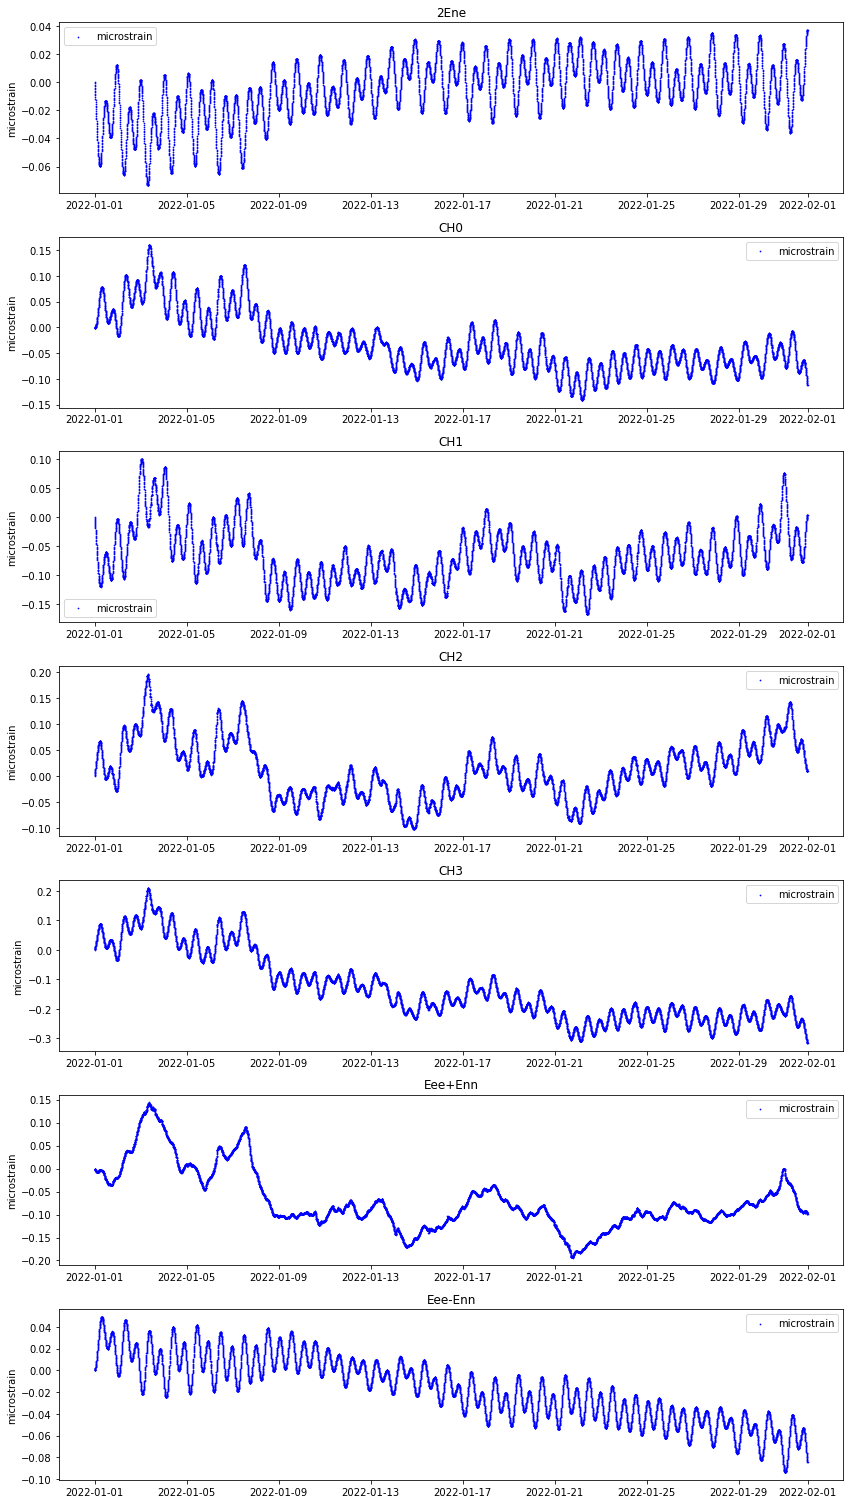

In [355]:
plot_data_type_subplots(df)

### Plot all gauge strains on the same plot.  Make another of regional strains.

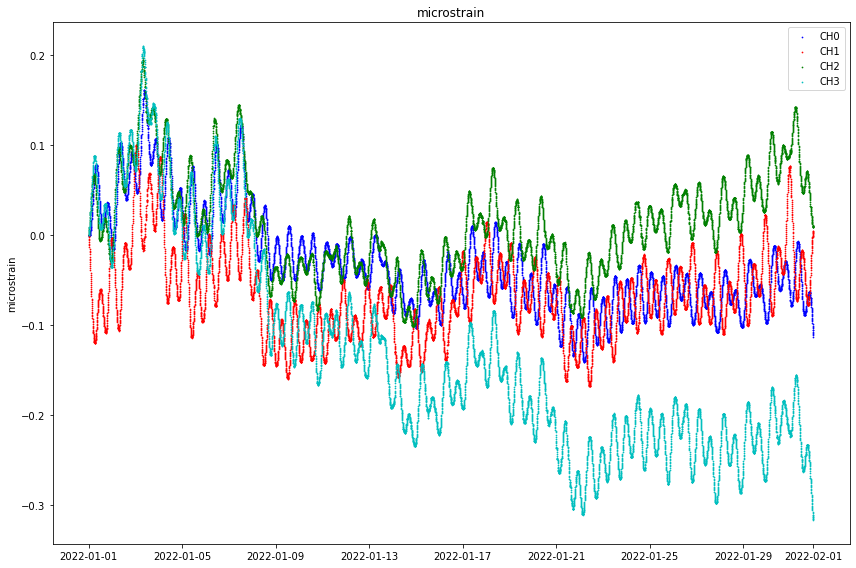

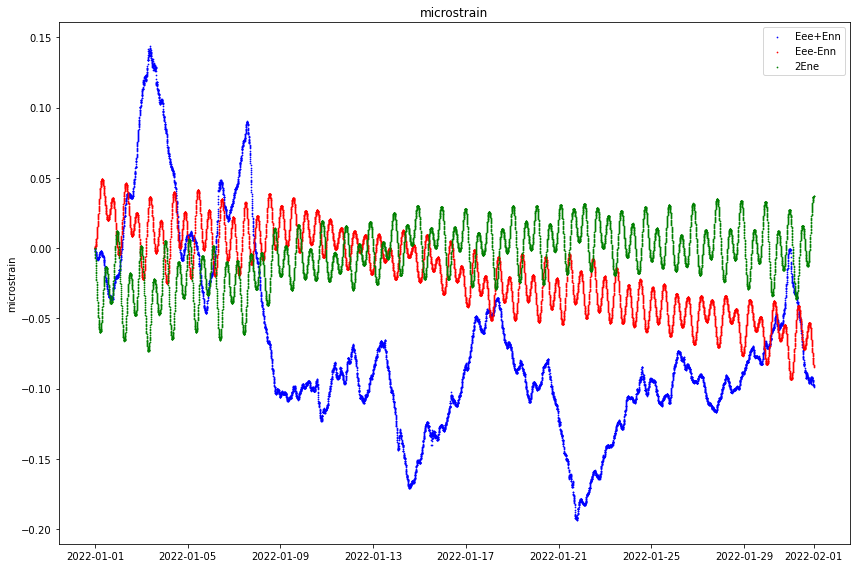

In [356]:
plot_multiindex(df.loc[['CH0','CH1','CH2','CH3']])
plot_multiindex(df.loc[['Eee+Enn','Eee-Enn','2Ene']])

## Load and display data for a single data_type (CH0) all timeseries (microstrain plus corrections).  Use same time window.


In [357]:
df = load_level2_tdb(uri, 
                     data_types='CH0',
                     attrs='data',
                     start=np.datetime64("2022-01-01T00:00:00"),
                     end=np.datetime64("2022-02-01T00:00:00")
                    )
display(df)


data
data_type timeseries time                        
CH0       atmp_c     2022-01-01 00:00:00 -0.20521
                     2022-01-01 00:05:00 -0.20540
                     2022-01-01 00:10:00 -0.20558
                     2022-01-01 00:15:00 -0.20576
                     2022-01-01 00:20:00 -0.20595
...                                           ...
          tide_c     2022-01-31 23:40:00 -0.02880
                     2022-01-31 23:45:00 -0.03015
                     2022-01-31 23:50:00 -0.03149
                     2022-01-31 23:55:00 -0.03281
                     2022-02-01 00:00:00 -0.03410

[44645 rows x 1 columns]

### Plot each timeseries on a separate subplot

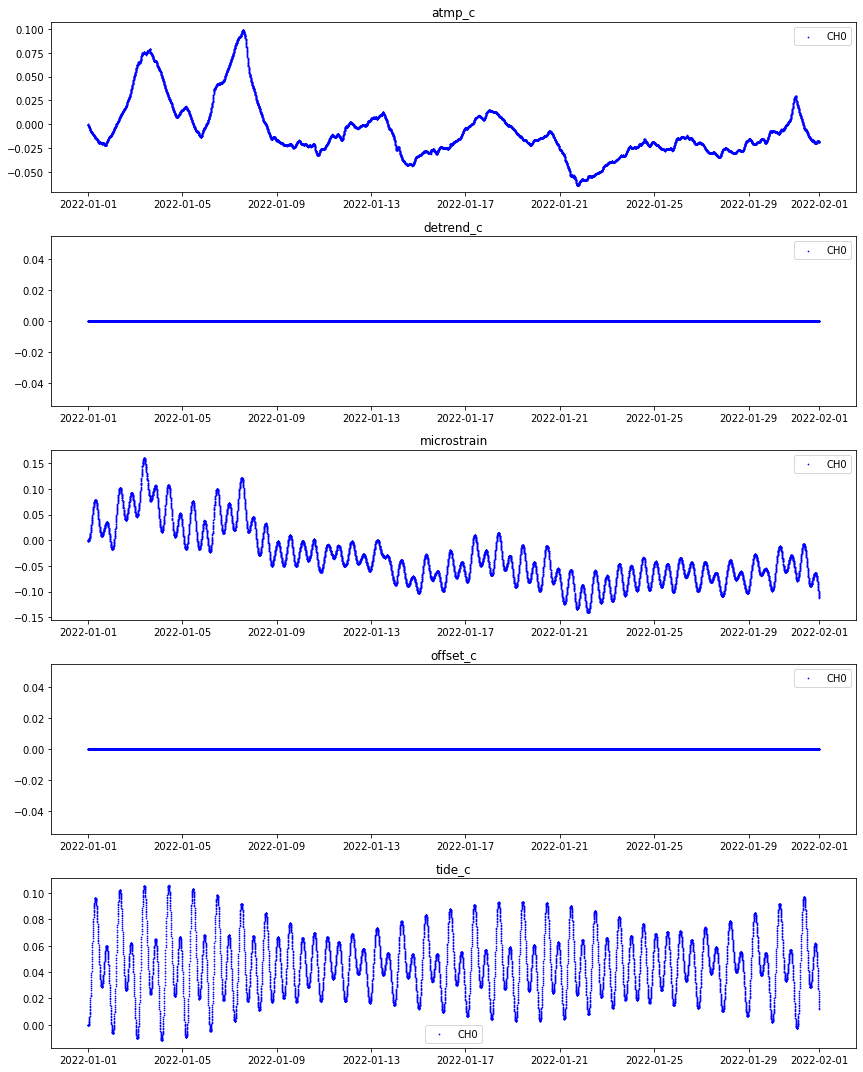

In [359]:
plot_timeseries_subplots(df)

### Plot a single timeseries.  if no timeseries specified, defaults to microstrain

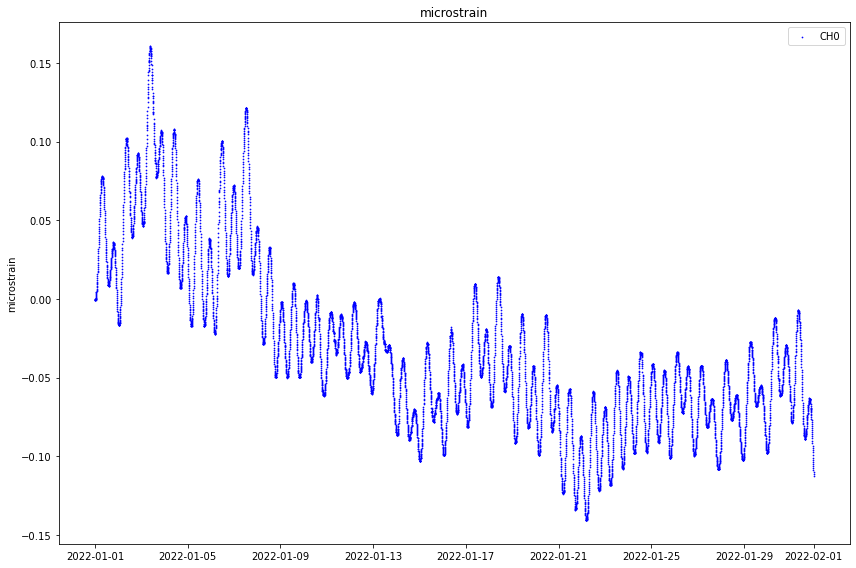

In [360]:
plot_multiindex(df)

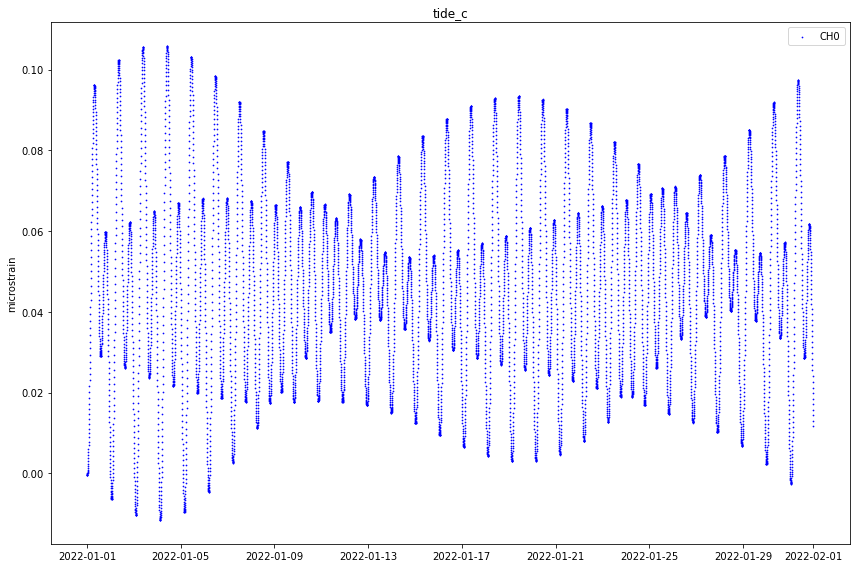

In [361]:
plot_multiindex(df, timeseries='tide_c')

### Plot corrected vs uncorrected data

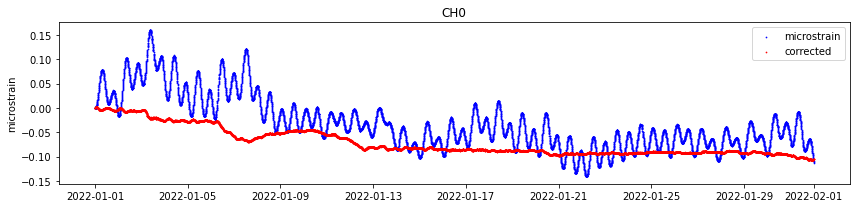

In [363]:
corrections = ['tide_c','atmp_c','detrend_c','offset_c']
plot_data_type_subplots(df, corrections=corrections)

## Load multiple data_types and timeseries

In [364]:
#load 4 channels microstrain and corrections
df = load_level2_tdb(uri,
                     data_types=['CH0','CH1','CH2','CH3'],
                     timeseries=['atmp_c', 'detrend_c', 'microstrain', 'offset_c', 'tide_c'],
                     attrs="data",
                     start=np.datetime64("2022-01-01T00:00:00"),
                     end=np.datetime64("2022-02-01T00:00:00")
                    )
display(df)



data
data_type timeseries time                        
CH0       atmp_c     2022-01-01 00:00:00 -0.20521
                     2022-01-01 00:05:00 -0.20540
                     2022-01-01 00:10:00 -0.20558
                     2022-01-01 00:15:00 -0.20576
                     2022-01-01 00:20:00 -0.20595
...                                           ...
CH3       tide_c     2022-01-31 23:40:00 -0.05694
                     2022-01-31 23:45:00 -0.05764
                     2022-01-31 23:50:00 -0.05826
                     2022-01-31 23:55:00 -0.05881
                     2022-02-01 00:00:00 -0.05929

[178580 rows x 1 columns]

### Plot each data_type on its own subplot, showing uncorrected and corrected data

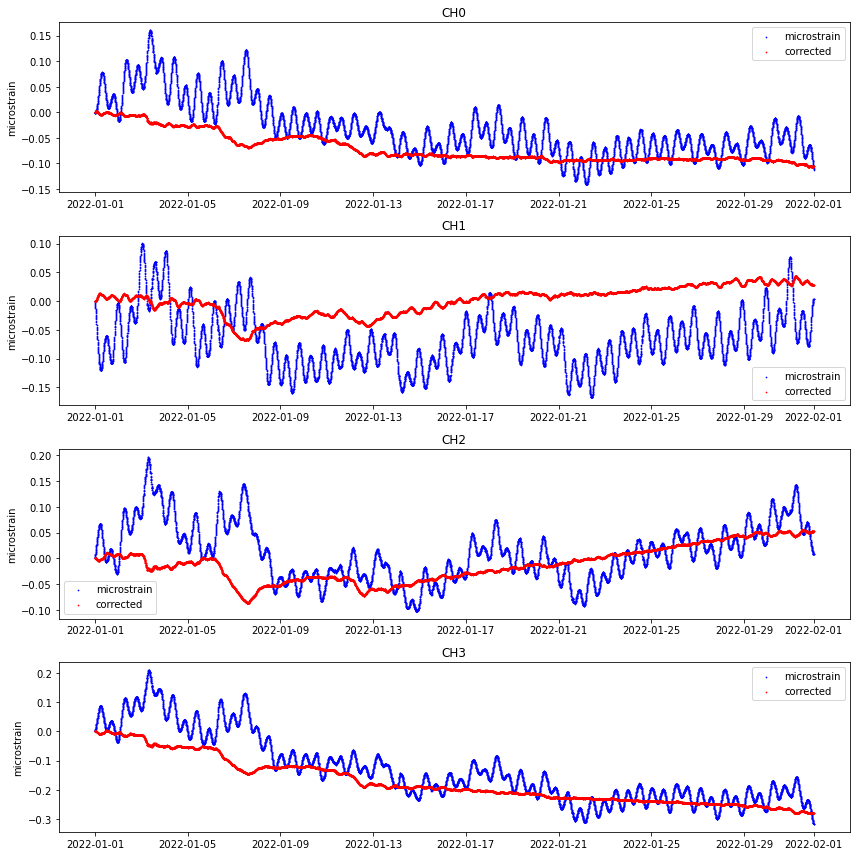

In [365]:
corrections = ['tide_c','atmp_c','detrend_c','offset_c']
plot_data_type_subplots(df, corrections=corrections)

### Plot each timeseries on its own subplot

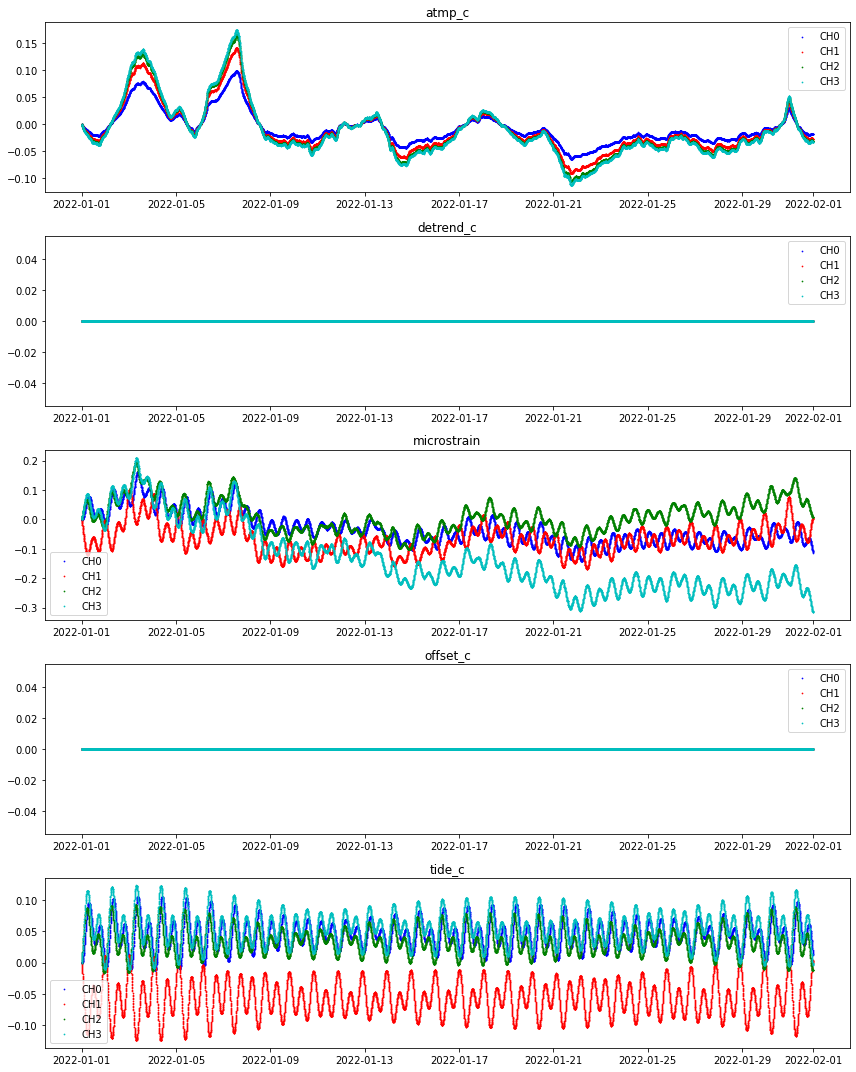

In [366]:
plot_timeseries_subplots(df)

## Load and plot regional microstrains and corrections

data
data_type timeseries time                        
2Ene      atmp_c     2022-01-01 00:00:00  0.04043
                     2022-01-01 00:05:00  0.04046
                     2022-01-01 00:10:00  0.04050
                     2022-01-01 00:15:00  0.04054
                     2022-01-01 00:20:00  0.04057
...                                           ...
Eee-Enn   tide_c     2022-01-31 23:40:00 -0.01797
                     2022-01-31 23:45:00 -0.01869
                     2022-01-31 23:50:00 -0.01939
                     2022-01-31 23:55:00 -0.02008
                     2022-02-01 00:00:00 -0.02075

[133935 rows x 1 columns]

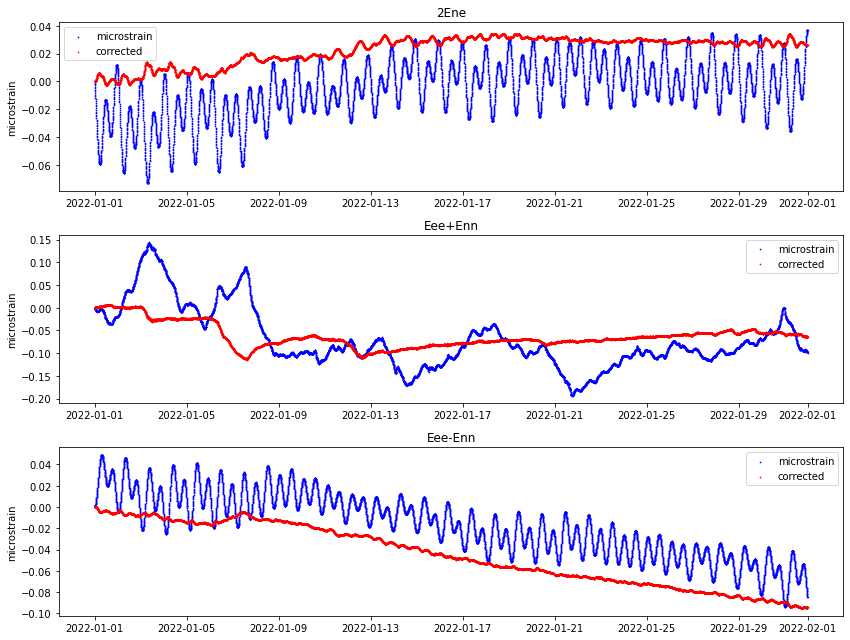

In [367]:
df = load_level2_tdb(uri,
                     data_types=['Eee+Enn','Eee-Enn','2Ene'],
                     timeseries=['atmp_c', 'detrend_c', 'microstrain', 'offset_c', 'tide_c'],
                     attrs="data",
                     start=np.datetime64("2022-01-01T00:00:00"),
                     end=np.datetime64("2022-02-01T00:00:00")
                    )
display(df)

corrections = ['tide_c','atmp_c','detrend_c','offset_c']
plot_data_type_subplots(df, corrections=corrections)

## Load and plot barometric pressure data

data
data_type timeseries time                        
pressure  atmp       2022-01-01 00:00:00  57.3245
                     2022-01-01 00:05:00  57.3765
                     2022-01-01 00:10:00  57.4275
                     2022-01-01 00:15:00  57.4795
                     2022-01-01 00:20:00  57.5315
...                                           ...
                     2022-01-31 23:40:00  62.5375
                     2022-01-31 23:45:00  62.5595
                     2022-01-31 23:50:00  62.5815
                     2022-01-31 23:55:00  62.6025
                     2022-02-01 00:00:00  62.6245

[8929 rows x 1 columns]

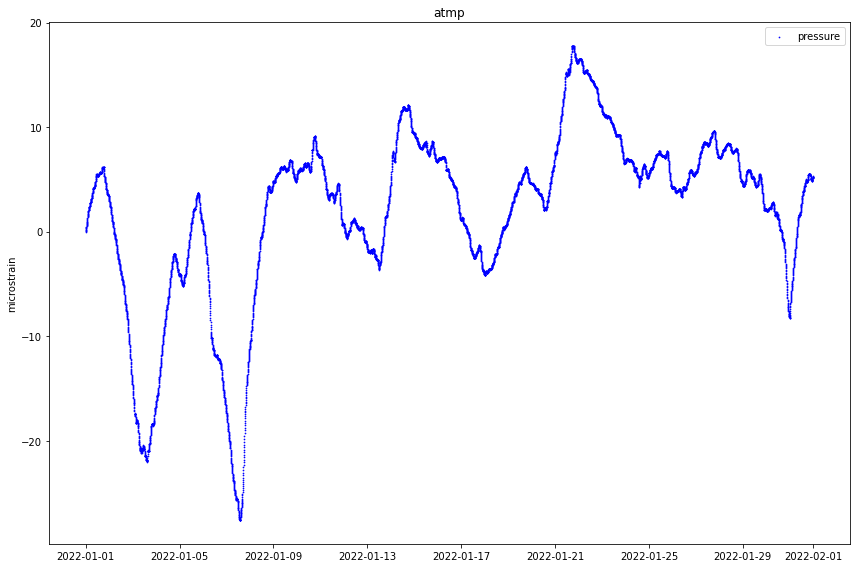

In [368]:
baro_df = load_level2_tdb(uri, 
                data_types=['pressure'],
                timeseries='atmp', 
                attrs="data",
                start=np.datetime64("2022-01-01T00:00:00"),
                end=np.datetime64("2022-02-01T00:00:00")
               )
display(baro_df)

plot_multiindex(baro_df, timeseries='atmp')

### Plot pressure data as another subplot

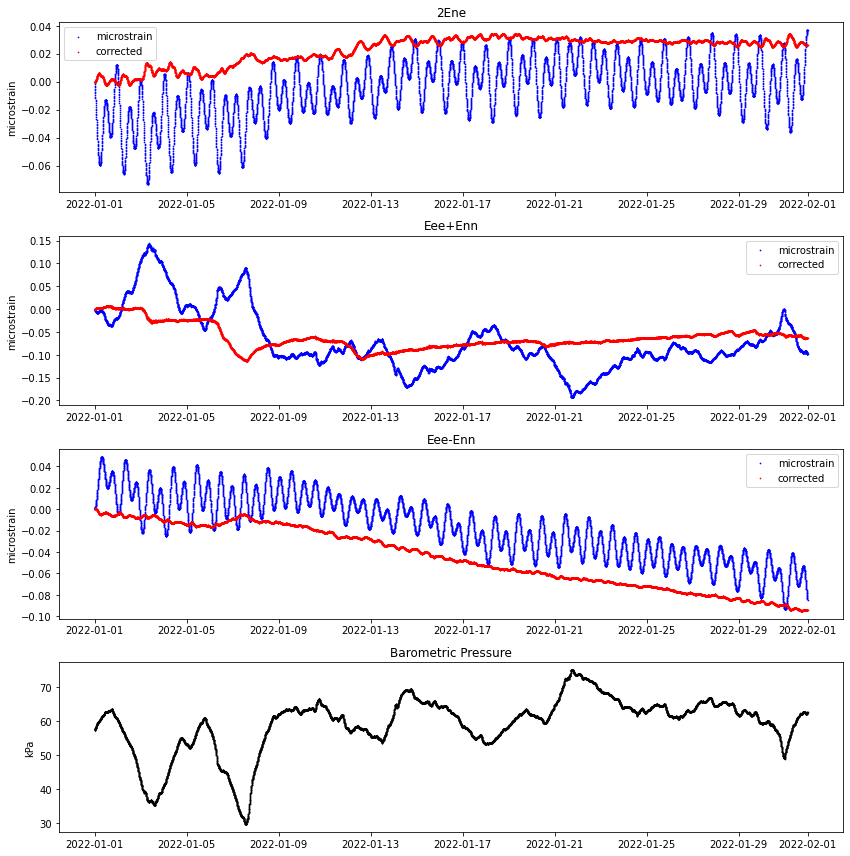

In [369]:
plot_data_type_subplots(df, corrections=corrections, baro_df=baro_df)

### Plot barometric pressure and pressure corrections

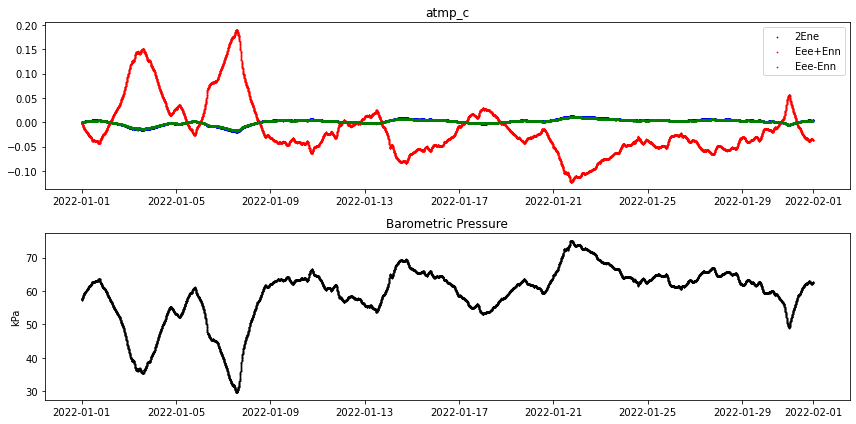

In [347]:
plot_timeseries_subplots(df.xs('atmp_c', level=1, drop_level=False), baro_df=baro_df)

## Remove multi-index, using data_types as columns
only works on a single timeseries and attribute

In [385]:
def reindex_data_types(df: pd.DataFrame,  
                       attr='data'):
    # removes a multi-index and makes each data_type/data a column
    data_types = list(df.index.get_level_values(0).unique())
    for data_type in data_types:
        df_data_type = df.xs(data_type, level='data_type')[attr].droplevel(level=0)
        df_data_type.name = data_type
        if data_type == data_types[0]:
            df2 = df_data_type
        else:
            df2 = pd.concat([df2, df_data_type], axis=1)
    return df2

df = load_level2_tdb(uri, 
                     timeseries='microstrain',
                     attrs='data',
                     start=np.datetime64("2022-01-01T00:00:00"),
                     end=np.datetime64("2022-02-01T00:00:00")
                    )

microstrain = reindex_data_types(df)
display("microstrain:", microstrain)

'microstrain:'

,2Ene,CH0,CH1,CH2,CH3,Eee+Enn,Eee-Enn
time,,,,,,,
2022-01-01 00:00:00,2.86616,-33.97896,1.98974,40.59499,-108.67087,-21.15466,-37.56011
2022-01-01 00:05:00,2.86520,-33.97906,1.98854,40.59632,-108.66972,-21.15466,-37.56009
2022-01-01 00:10:00,2.86420,-33.97920,1.98711,40.59757,-108.66865,-21.15483,-37.56003
2022-01-01 00:15:00,2.86322,-33.97951,1.98524,40.59840,-108.66793,-21.15549,-37.55986
2022-01-01 00:20:00,2.86211,-33.97939,1.98373,40.59987,-108.66651,-21.15549,-37.55970
...,...,...,...,...,...,...,...
2022-01-31 23:40:00,2.90277,-34.08622,1.99237,40.60439,-108.98429,-21.25193,-37.64221
2022-01-31 23:45:00,2.90288,-34.08751,1.99308,40.60441,-108.98492,-21.25208,-37.64290
2022-01-31 23:50:00,2.90299,-34.08883,1.99353,40.60422,-108.98572,-21.25247,-37.64352


## Remove multiindex, using timeseries as columns
only works on a single data_type and attribute

In [386]:
def reindex_timeseries(df: pd.DataFrame,  
                       attr='data'):
    # removes a multi-index and makes each data_type a column
    timeseries_list = list(df.index.get_level_values(1).unique())
    for timeseries in timeseries_list:
        df_timeseries = df.xs(timeseries, level='timeseries')[attr].droplevel(level=0)
        df_timeseries.name = timeseries
        if timeseries == timeseries_list[0]:
            df2 = df_timeseries
        else:
            df2 = pd.concat([df2, df_timeseries], axis=1)
    return df2

df = load_level2_tdb(uri, 
                     data_types='CH0',
                     attrs='data',
                     start=np.datetime64("2022-01-01T00:00:00"),
                     end=np.datetime64("2022-02-01T00:00:00")
                    )

CH0 = reindex_timeseries(df)
display("CH0:", CH0)

'CH0:'

,atmp_c,detrend_c,microstrain,offset_c,tide_c
time,,,,,
2022-01-01 00:00:00,-0.20521,0.0,-33.97896,0.67775,-0.04586
2022-01-01 00:05:00,-0.20540,0.0,-33.97906,0.67775,-0.04606
2022-01-01 00:10:00,-0.20558,0.0,-33.97920,0.67775,-0.04622
2022-01-01 00:15:00,-0.20576,0.0,-33.97951,0.67775,-0.04631
2022-01-01 00:20:00,-0.20595,0.0,-33.97939,0.67775,-0.04635
...,...,...,...,...,...
2022-01-31 23:40:00,-0.22387,0.0,-34.08622,0.67775,-0.02880
2022-01-31 23:45:00,-0.22395,0.0,-34.08751,0.67775,-0.03015
2022-01-31 23:50:00,-0.22403,0.0,-34.08883,0.67775,-0.03149


## Use quality attribute
can check how much data is good, bad, missing, interpolated

In [410]:
df = load_level2_tdb(uri, 
                     data_types='CH0',
                     attrs='quality',
                     start=np.datetime64("2022-01-01T00:00:00"),
                     end=np.datetime64("2023-01-01T00:00:00")
                    )
timeseries_list = list(df.index.get_level_values(1).unique())
for timeseries in timeseries_list:
    total = len(reindex_timeseries(df, attr='quality')[timeseries])
    quality_totals = reindex_timeseries(df, attr='quality')[timeseries].value_counts()
    if quality_totals.index[0] != " ":
        print(f"Total {timeseries} data points: {total}")
        for key in quality_totals.index:
            print(f"   {key} flags: {quality_totals[key]}, {round(quality_totals[key]/total * 100, 3)}%")


Total atmp_c data points: 104831
   i flags: 86555, 82.566%
   g flags: 17314, 16.516%
   m flags: 962, 0.918%
Total microstrain data points: 104831
   g flags: 103868, 99.081%
   m flags: 963, 0.919%
